# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time
wait_to_make = "trained_list/roberta-large-test.txt"
count = 0
while 1:
    if os.path.exists(wait_to_make):
        break
    print(f'sleep {count} h')
    time.sleep(3600)
    count+=1
    
local = True

sleep 0 h
sleep 1 h
sleep 2 h
sleep 3 h
sleep 4 h


In [2]:
EXP_NAME = "bert-large-uncased-whole-word-masking-finetuned-squad"
# "bert-base-uncased"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime
if local:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
else:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    # model = "bert-base-uncased"
    model = "bert-large-uncased-whole-word-masking-finetuned-squad"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model or "medium" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=8
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=16
    
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.6
transformers.__version__: 4.17.0
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

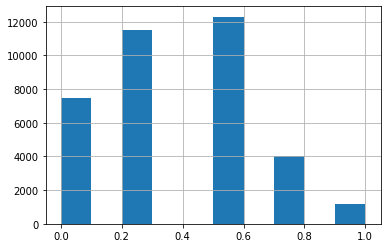

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        try:
                if isinstance(module, nn.Linear):
                    module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                    if module.bias is not None:
                        module.bias.data.zero_()
                elif isinstance(module, nn.Embedding):
                    module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
                    if module.padding_idx is not None:
                        module.weight.data[module.padding_idx].zero_()
                elif isinstance(module, nn.LayerNorm):
                    module.bias.data.zero_()
                    module.weight.data.fill_(1.0)
        except:
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=0.02)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)

    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    


# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            # if fold in [0,1,2]:
                #continue
               # print（f”￥０r３３［３８；５；４０m＝＝＝＝＝＝＝＝＝＝ this fold is pass ￥ontinue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1709] Elapsed 0m 0s (remain 23m 10s) Loss: 0.6651(0.6651) Grad: 186084.1250  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 44s (remain 11m 52s) Loss: 0.6401(0.6565) Grad: 36337.2109  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 28s (remain 11m 6s) Loss: 0.6611(0.6329) Grad: 61880.0312  LR: 0.00001999  
Epoch: [1][300/1709] Elapsed 2m 13s (remain 10m 22s) Loss: 0.5669(0.6239) Grad: 48321.3945  LR: 0.00001998  
Epoch: [1][400/1709] Elapsed 2m 57s (remain 9m 37s) Loss: 0.5417(0.6137) Grad: 59451.1719  LR: 0.00001996  
Epoch: [1][500/1709] Elapsed 3m 41s (remain 8m 53s) Loss: 0.6090(0.6082) Grad: 107051.2969  LR: 0.00001993  
Epoch: [1][600/1709] Elapsed 4m 25s (remain 8m 9s) Loss: 0.5344(0.6035) Grad: 65432.4180  LR: 0.00001990  
Epoch: [1][700/1709] Elapsed 5m 9s (remain 7m 25s) Loss: 0.5632(0.5981) Grad: 35178.8906  LR: 0.00001987  
Epoch: [1][800/1709] Elapsed 5m 54s (remain 6m 41s) Loss: 0.6410(0.5953) Grad: 90804.4766  LR: 0.00001983  
Epoch: [1][900/1709] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 50s) Loss: 0.6135(0.6135) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4823(0.5606) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5740(0.5574) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5886(0.5581) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.6722(0.5570) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5747(0.5571) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 1 - avg_train_loss: 0.5784  avg_val_loss: 0.5558  time: 844s
Epoch 1 - Score: 0.7951
Epoch 1 - Save Best Score: 0.7951 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.5165(0.5558) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1709] Elapsed 0m 0s (remain 21m 27s) Loss: 0.5367(0.5367) Grad: inf  LR: 0.00001924  
Epoch: [2][100/1709] Elapsed 0m 44s (remain 11m 55s) Loss: 0.5241(0.5306) Grad: 72075.3125  LR: 0.00001915  
Epoch: [2][200/1709] Elapsed 1m 29s (remain 11m 10s) Loss: 0.6651(0.5321) Grad: 231474.7344  LR: 0.00001905  
Epoch: [2][300/1709] Elapsed 2m 13s (remain 10m 25s) Loss: 0.5653(0.5326) Grad: 36195.4922  LR: 0.00001895  
Epoch: [2][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.5985(0.5348) Grad: 35036.9844  LR: 0.00001885  
Epoch: [2][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.4999(0.5356) Grad: 19062.6270  LR: 0.00001874  
Epoch: [2][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.5810(0.5360) Grad: 40239.3164  LR: 0.00001863  
Epoch: [2][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.5510(0.5357) Grad: 66751.8594  LR: 0.00001851  
Epoch: [2][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.6334(0.5363) Grad: 216245.6719  LR: 0.00001838  
Epoch: [2][900/1709] Elapsed 6m 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 50s) Loss: 0.6170(0.6170) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5085(0.5842) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.6359(0.5796) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.7019(0.5764) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.6952(0.5744) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5934(0.5765) 


Epoch 2 - avg_train_loss: 0.5394  avg_val_loss: 0.5748  time: 844s
Epoch 2 - Score: 0.7867


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4741(0.5748) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1709] Elapsed 0m 0s (remain 14m 25s) Loss: 0.5872(0.5872) Grad: 117832.0859  LR: 0.00001707  
Epoch: [3][100/1709] Elapsed 0m 44s (remain 11m 51s) Loss: 0.4358(0.5189) Grad: 22290.5234  LR: 0.00001691  
Epoch: [3][200/1709] Elapsed 1m 29s (remain 11m 8s) Loss: 0.5795(0.5266) Grad: 37158.2305  LR: 0.00001674  
Epoch: [3][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.3686(0.5227) Grad: 51023.4375  LR: 0.00001657  
Epoch: [3][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.4369(0.5225) Grad: 40966.3086  LR: 0.00001639  
Epoch: [3][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.5136(0.5217) Grad: 33303.3984  LR: 0.00001621  
Epoch: [3][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.4137(0.5202) Grad: 8042.3364  LR: 0.00001603  
Epoch: [3][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.5526(0.5181) Grad: 89511.6875  LR: 0.00001585  
Epoch: [3][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.5050(0.5185) Grad: 20860.3379  LR: 0.00001566  
Epoch: [3][900/1709] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][1708/1709] Elapsed 12m 38s (remain 0m 0s) Loss: 0.5400(0.5192) Grad: 28309.8652  LR: 0.00001383  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 47s) Loss: 0.5753(0.5753) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4473(0.5625) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5477(0.5579) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5767(0.5594) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.8361(0.5595) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5849(0.5597) 


Epoch 3 - avg_train_loss: 0.5192  avg_val_loss: 0.5578  time: 845s
Epoch 3 - Score: 0.8308
Epoch 3 - Save Best Score: 0.8308 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4866(0.5578) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1709] Elapsed 0m 0s (remain 19m 56s) Loss: 0.5556(0.5556) Grad: 298804.1562  LR: 0.00001383  
Epoch: [4][100/1709] Elapsed 0m 44s (remain 11m 54s) Loss: 0.6003(0.5178) Grad: 21981.7891  LR: 0.00001362  
Epoch: [4][200/1709] Elapsed 1m 30s (remain 11m 16s) Loss: 0.6453(0.5076) Grad: 138128.9375  LR: 0.00001340  
Epoch: [4][300/1709] Elapsed 2m 14s (remain 10m 29s) Loss: 0.3888(0.5060) Grad: 12524.4092  LR: 0.00001318  
Epoch: [4][400/1709] Elapsed 2m 58s (remain 9m 43s) Loss: 0.4825(0.5054) Grad: 139465.0156  LR: 0.00001296  
Epoch: [4][500/1709] Elapsed 3m 43s (remain 8m 58s) Loss: 0.5317(0.5070) Grad: 97895.6719  LR: 0.00001274  
Epoch: [4][600/1709] Elapsed 4m 27s (remain 8m 13s) Loss: 0.5204(0.5064) Grad: 65195.1016  LR: 0.00001252  
Epoch: [4][700/1709] Elapsed 5m 11s (remain 7m 28s) Loss: 0.4309(0.5052) Grad: 197923.3281  LR: 0.00001230  
Epoch: [4][800/1709] Elapsed 5m 56s (remain 6m 43s) Loss: 0.5352(0.5035) Grad: 102588.0938  LR: 0.00001208  
Epoch: [4][900/1709] E

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][1708/1709] Elapsed 12m 39s (remain 0m 0s) Loss: 0.5301(0.5035) Grad: 237519.3906  LR: 0.00001001  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 48s) Loss: 0.5644(0.5644) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4507(0.5795) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5899(0.5709) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.7695(0.5714) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.8309(0.5721) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5747(0.5709) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 4 - avg_train_loss: 0.5035  avg_val_loss: 0.5691  time: 846s
Epoch 4 - Score: 0.8378
Epoch 4 - Save Best Score: 0.8378 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4648(0.5691) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/1709] Elapsed 0m 0s (remain 21m 7s) Loss: 0.4345(0.4345) Grad: 51778.3398  LR: 0.00001000  
Epoch: [5][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.5719(0.4913) Grad: 326656.1875  LR: 0.00000977  
Epoch: [5][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.5604(0.4934) Grad: 53342.2852  LR: 0.00000954  
Epoch: [5][300/1709] Elapsed 2m 13s (remain 10m 25s) Loss: 0.3918(0.4967) Grad: 80364.9531  LR: 0.00000931  
Epoch: [5][400/1709] Elapsed 2m 58s (remain 9m 40s) Loss: 0.5313(0.4962) Grad: 60751.5820  LR: 0.00000909  
Epoch: [5][500/1709] Elapsed 3m 42s (remain 8m 56s) Loss: 0.5838(0.4958) Grad: 37869.4297  LR: 0.00000886  
Epoch: [5][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.5522(0.4957) Grad: 32516.4219  LR: 0.00000863  
Epoch: [5][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.4670(0.4945) Grad: 8741.9277  LR: 0.00000840  
Epoch: [5][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.4004(0.4934) Grad: 9911.7568  LR: 0.00000818  
Epoch: [5][900/1709] Elapsed 6

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 45s) Loss: 0.5587(0.5587) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4871(0.5775) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.5472(0.5702) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6016(0.5729) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.7567(0.5714) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5794(0.5710) 


Epoch 5 - avg_train_loss: 0.4962  avg_val_loss: 0.5704  time: 844s
Epoch 5 - Score: 0.8379
Epoch 5 - Save Best Score: 0.8379 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4659(0.5704) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/1709] Elapsed 0m 0s (remain 19m 44s) Loss: 0.5513(0.5513) Grad: 13815.4893  LR: 0.00000618  
Epoch: [6][100/1709] Elapsed 0m 44s (remain 11m 56s) Loss: 0.5682(0.4940) Grad: 56688.2812  LR: 0.00000597  
Epoch: [6][200/1709] Elapsed 1m 29s (remain 11m 10s) Loss: 0.4561(0.4841) Grad: 28509.4277  LR: 0.00000576  
Epoch: [6][300/1709] Elapsed 2m 13s (remain 10m 25s) Loss: 0.4615(0.4829) Grad: 161017.5000  LR: 0.00000555  
Epoch: [6][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.5492(0.4859) Grad: 25176.8574  LR: 0.00000535  
Epoch: [6][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.5210(0.4881) Grad: 20580.3008  LR: 0.00000514  
Epoch: [6][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.4062(0.4886) Grad: 30280.0879  LR: 0.00000494  
Epoch: [6][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.4765(0.4898) Grad: 29290.0742  LR: 0.00000475  
Epoch: [6][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.5373(0.4904) Grad: 20044.8594  LR: 0.00000455  
Epoch: [6][900/1709] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 46s) Loss: 0.5482(0.5482) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4478(0.5749) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.5557(0.5701) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5956(0.5730) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.7460(0.5733) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5801(0.5726) 


Epoch 6 - avg_train_loss: 0.4905  avg_val_loss: 0.5717  time: 844s
Epoch 6 - Score: 0.8432
Epoch 6 - Save Best Score: 0.8432 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4668(0.5717) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/1709] Elapsed 0m 0s (remain 21m 45s) Loss: 0.6393(0.6393) Grad: 86852.6094  LR: 0.00000293  
Epoch: [7][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.4223(0.4965) Grad: 39108.1641  LR: 0.00000277  
Epoch: [7][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.5072(0.4862) Grad: 27609.5703  LR: 0.00000262  
Epoch: [7][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.5753(0.4893) Grad: 16183.0664  LR: 0.00000246  
Epoch: [7][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.3870(0.4866) Grad: 11998.3262  LR: 0.00000231  
Epoch: [7][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.4332(0.4874) Grad: 13592.7412  LR: 0.00000217  
Epoch: [7][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.4711(0.4888) Grad: 13201.5020  LR: 0.00000203  
Epoch: [7][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.4922(0.4864) Grad: 10880.3369  LR: 0.00000189  
Epoch: [7][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.4349(0.4871) Grad: 15060.6875  LR: 0.00000176  
Epoch: [7][900/1709] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][1708/1709] Elapsed 12m 37s (remain 0m 0s) Loss: 0.5833(0.4867) Grad: 16325.8896  LR: 0.00000077  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 48s) Loss: 0.5492(0.5492) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4457(0.5784) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.5515(0.5712) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6749(0.5758) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.7518(0.5749) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5798(0.5741) 


Epoch 7 - avg_train_loss: 0.4867  avg_val_loss: 0.5732  time: 844s
Epoch 7 - Score: 0.8433
Epoch 7 - Save Best Score: 0.8433 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4666(0.5732) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/1709] Elapsed 0m 0s (remain 22m 4s) Loss: 0.5284(0.5284) Grad: 102789.0547  LR: 0.00000076  
Epoch: [8][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.3962(0.4783) Grad: 37559.9141  LR: 0.00000068  
Epoch: [8][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.5334(0.4801) Grad: 24067.6348  LR: 0.00000060  
Epoch: [8][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.4063(0.4807) Grad: 33032.3594  LR: 0.00000052  
Epoch: [8][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.4128(0.4797) Grad: 38200.4688  LR: 0.00000045  
Epoch: [8][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.4649(0.4833) Grad: 12673.3623  LR: 0.00000039  
Epoch: [8][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.5762(0.4826) Grad: 19272.1289  LR: 0.00000033  
Epoch: [8][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.5704(0.4822) Grad: 14884.4990  LR: 0.00000027  
Epoch: [8][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.5365(0.4830) Grad: 25960.1855  LR: 0.00000022  
Epoch: [8][900/1709] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 48s) Loss: 0.5464(0.5464) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.4457(0.5779) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.5531(0.5709) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6864(0.5755) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.7525(0.5747) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5811(0.5739) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 8 - avg_train_loss: 0.4852  avg_val_loss: 0.5730  time: 844s
Epoch 8 - Score: 0.8432


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4657(0.5730) 


========== fold: 0 result ==========
Score: 0.8433
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (fun

Epoch: [1][0/1709] Elapsed 0m 0s (remain 16m 5s) Loss: 0.6794(0.6794) Grad: 260279.4844  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 44s (remain 11m 48s) Loss: 0.5847(0.6410) Grad: 78244.9375  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 28s (remain 11m 6s) Loss: 0.6337(0.6215) Grad: 65807.7812  LR: 0.00001999  
Epoch: [1][300/1709] Elapsed 2m 13s (remain 10m 22s) Loss: 0.6480(0.6174) Grad: 31549.5742  LR: 0.00001998  
Epoch: [1][400/1709] Elapsed 2m 57s (remain 9m 38s) Loss: 0.5353(0.6129) Grad: 9486.4131  LR: 0.00001996  
Epoch: [1][500/1709] Elapsed 3m 41s (remain 8m 54s) Loss: 0.7109(0.6090) Grad: 17202.0723  LR: 0.00001993  
Epoch: [1][600/1709] Elapsed 4m 26s (remain 8m 10s) Loss: 0.5585(0.6079) Grad: 10781.9482  LR: 0.00001990  
Epoch: [1][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.6137(0.6035) Grad: 26257.9844  LR: 0.00001987  
Epoch: [1][800/1709] Elapsed 5m 54s (remain 6m 42s) Loss: 0.5427(0.5997) Grad: 8335.8193  LR: 0.00001983  
Epoch: [1][900/1709] Elapsed 6

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 57s) Loss: 0.5532(0.5532) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.6512(0.5627) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.4458(0.5675) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6435(0.5694) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.6111(0.5711) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.5023(0.5683) 


Epoch 1 - avg_train_loss: 0.5817  avg_val_loss: 0.5676  time: 844s
Epoch 1 - Score: 0.7925
Epoch 1 - Save Best Score: 0.7925 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4472(0.5676) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1709] Elapsed 0m 0s (remain 20m 11s) Loss: 0.5218(0.5218) Grad: 252707.7188  LR: 0.00001924  
Epoch: [2][100/1709] Elapsed 0m 44s (remain 11m 54s) Loss: 0.5655(0.5421) Grad: 44318.9219  LR: 0.00001915  
Epoch: [2][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.6174(0.5350) Grad: 78430.4922  LR: 0.00001905  
Epoch: [2][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.5842(0.5371) Grad: 38170.9766  LR: 0.00001895  
Epoch: [2][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.4357(0.5365) Grad: 72071.7891  LR: 0.00001885  
Epoch: [2][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.5274(0.5354) Grad: 19744.0293  LR: 0.00001874  
Epoch: [2][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.5798(0.5336) Grad: 73547.6562  LR: 0.00001863  
Epoch: [2][700/1709] Elapsed 5m 10s (remain 7m 27s) Loss: 0.3852(0.5323) Grad: 87763.3672  LR: 0.00001851  
Epoch: [2][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.5665(0.5315) Grad: 36466.4023  LR: 0.00001838  
Epoch: [2][900/1709] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][1708/1709] Elapsed 12m 37s (remain 0m 0s) Loss: 0.3737(0.5319) Grad: 9468.2734  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 56s) Loss: 0.5978(0.5978) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.6198(0.5684) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.4330(0.5735) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5911(0.5739) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5502(0.5763) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4857(0.5732) 


Epoch 2 - avg_train_loss: 0.5319  avg_val_loss: 0.5725  time: 844s
Epoch 2 - Score: 0.7893


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4991(0.5725) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1709] Elapsed 0m 0s (remain 15m 0s) Loss: 0.4950(0.4950) Grad: 84598.4922  LR: 0.00001707  
Epoch: [3][100/1709] Elapsed 0m 44s (remain 11m 51s) Loss: 0.5961(0.5233) Grad: 46019.8789  LR: 0.00001691  
Epoch: [3][200/1709] Elapsed 1m 29s (remain 11m 7s) Loss: 0.6374(0.5226) Grad: 23742.1797  LR: 0.00001674  
Epoch: [3][300/1709] Elapsed 2m 13s (remain 10m 23s) Loss: 0.5433(0.5254) Grad: 34377.8750  LR: 0.00001657  
Epoch: [3][400/1709] Elapsed 2m 57s (remain 9m 39s) Loss: 0.5711(0.5271) Grad: 53831.4570  LR: 0.00001639  
Epoch: [3][500/1709] Elapsed 3m 41s (remain 8m 55s) Loss: 0.5136(0.5246) Grad: 29343.8809  LR: 0.00001621  
Epoch: [3][600/1709] Elapsed 4m 26s (remain 8m 10s) Loss: 0.5724(0.5240) Grad: 17358.0312  LR: 0.00001603  
Epoch: [3][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.4967(0.5236) Grad: 11586.8213  LR: 0.00001585  
Epoch: [3][800/1709] Elapsed 5m 54s (remain 6m 42s) Loss: 0.6075(0.5207) Grad: 13637.0205  LR: 0.00001566  
Epoch: [3][900/1709] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 55s) Loss: 0.4952(0.4952) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.6164(0.5488) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.3948(0.5538) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6203(0.5580) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5245(0.5596) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4840(0.5594) 


Epoch 3 - avg_train_loss: 0.5226  avg_val_loss: 0.5597  time: 844s
Epoch 3 - Score: 0.8216
Epoch 3 - Save Best Score: 0.8216 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.5171(0.5597) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1709] Elapsed 0m 0s (remain 20m 59s) Loss: 0.6037(0.6037) Grad: 112004.5000  LR: 0.00001383  
Epoch: [4][100/1709] Elapsed 0m 44s (remain 11m 55s) Loss: 0.4225(0.4971) Grad: 36591.3203  LR: 0.00001362  
Epoch: [4][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.4364(0.5047) Grad: 42760.4727  LR: 0.00001340  
Epoch: [4][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.6378(0.5080) Grad: 104565.2969  LR: 0.00001318  
Epoch: [4][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.3795(0.5093) Grad: 70309.4922  LR: 0.00001296  
Epoch: [4][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.4744(0.5065) Grad: 146074.7188  LR: 0.00001274  
Epoch: [4][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.4872(0.5057) Grad: 18044.3027  LR: 0.00001252  
Epoch: [4][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.5742(0.5072) Grad: 14971.2998  LR: 0.00001230  
Epoch: [4][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.4485(0.5062) Grad: 29851.1523  LR: 0.00001208  
Epoch: [4][900/1709] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][1708/1709] Elapsed 12m 37s (remain 0m 0s) Loss: 0.3610(0.5072) Grad: 42700.2109  LR: 0.00001001  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 5s) Loss: 0.4966(0.4966) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5833(0.5443) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.3787(0.5496) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6122(0.5518) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5284(0.5535) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4768(0.5510) 


Epoch 4 - avg_train_loss: 0.5072  avg_val_loss: 0.5496  time: 844s
Epoch 4 - Score: 0.8327
Epoch 4 - Save Best Score: 0.8327 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.3896(0.5496) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/1709] Elapsed 0m 0s (remain 23m 5s) Loss: 0.4552(0.4552) Grad: 77645.8516  LR: 0.00001000  
Epoch: [5][100/1709] Elapsed 0m 44s (remain 11m 56s) Loss: 0.3795(0.4922) Grad: 24678.9883  LR: 0.00000977  
Epoch: [5][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.3537(0.4919) Grad: 25963.0605  LR: 0.00000954  
Epoch: [5][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.4811(0.4926) Grad: 36303.8125  LR: 0.00000931  
Epoch: [5][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.5220(0.4956) Grad: 28427.9746  LR: 0.00000909  
Epoch: [5][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.4769(0.4957) Grad: 18050.2090  LR: 0.00000886  
Epoch: [5][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.5618(0.4967) Grad: 74174.1328  LR: 0.00000863  
Epoch: [5][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.4184(0.4969) Grad: 17149.6953  LR: 0.00000840  
Epoch: [5][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.4208(0.4962) Grad: 5454.4800  LR: 0.00000818  
Epoch: [5][900/1709] Elapsed 6

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 55s) Loss: 0.5053(0.5053) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5890(0.5573) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 55s) Loss: 0.3816(0.5609) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6317(0.5650) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5110(0.5672) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4960(0.5639) 


Epoch 5 - avg_train_loss: 0.4988  avg_val_loss: 0.5630  time: 844s
Epoch 5 - Score: 0.8354
Epoch 5 - Save Best Score: 0.8354 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4135(0.5630) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/1709] Elapsed 0m 0s (remain 22m 27s) Loss: 0.5044(0.5044) Grad: 105353.0469  LR: 0.00000618  
Epoch: [6][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.4785(0.5004) Grad: 425574.9688  LR: 0.00000597  
Epoch: [6][200/1709] Elapsed 1m 29s (remain 11m 10s) Loss: 0.3990(0.4899) Grad: 66328.7109  LR: 0.00000576  
Epoch: [6][300/1709] Elapsed 2m 13s (remain 10m 25s) Loss: 0.5333(0.4910) Grad: 164819.7500  LR: 0.00000555  
Epoch: [6][400/1709] Elapsed 2m 58s (remain 9m 40s) Loss: 0.4557(0.4919) Grad: 31817.6934  LR: 0.00000535  
Epoch: [6][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.4377(0.4928) Grad: 81338.2578  LR: 0.00000514  
Epoch: [6][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.4931(0.4925) Grad: 14892.4434  LR: 0.00000494  
Epoch: [6][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.6228(0.4927) Grad: 8538.0811  LR: 0.00000475  
Epoch: [6][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.5703(0.4911) Grad: 12244.1670  LR: 0.00000455  
Epoch: [6][900/1709] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 56s) Loss: 0.5062(0.5062) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5883(0.5688) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.3742(0.5708) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5934(0.5731) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5300(0.5746) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4828(0.5706) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 6 - avg_train_loss: 0.4922  avg_val_loss: 0.5710  time: 844s
Epoch 6 - Score: 0.8367
Epoch 6 - Save Best Score: 0.8367 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4298(0.5710) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/1709] Elapsed 0m 0s (remain 22m 41s) Loss: 0.4905(0.4905) Grad: 446348.5938  LR: 0.00000293  
Epoch: [7][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.5113(0.4817) Grad: 1255310.2500  LR: 0.00000277  
Epoch: [7][200/1709] Elapsed 1m 29s (remain 11m 9s) Loss: 0.5078(0.4904) Grad: 43474.5508  LR: 0.00000262  
Epoch: [7][300/1709] Elapsed 2m 13s (remain 10m 24s) Loss: 0.6001(0.4891) Grad: 31078.1484  LR: 0.00000246  
Epoch: [7][400/1709] Elapsed 2m 57s (remain 9m 40s) Loss: 0.5330(0.4876) Grad: 1227054.6250  LR: 0.00000231  
Epoch: [7][500/1709] Elapsed 3m 42s (remain 8m 55s) Loss: 0.3687(0.4843) Grad: 17453.4727  LR: 0.00000217  
Epoch: [7][600/1709] Elapsed 4m 26s (remain 8m 11s) Loss: 0.4945(0.4849) Grad: 226341.7656  LR: 0.00000203  
Epoch: [7][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.4740(0.4850) Grad: 213115.5938  LR: 0.00000189  
Epoch: [7][800/1709] Elapsed 5m 55s (remain 6m 42s) Loss: 0.4427(0.4858) Grad: 31522.2031  LR: 0.00000176  
Epoch: [7][900/1709] 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][1708/1709] Elapsed 12m 37s (remain 0m 0s) Loss: 0.4627(0.4880) Grad: 18759.5176  LR: 0.00000077  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 58s) Loss: 0.4961(0.4961) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5863(0.5643) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.3754(0.5694) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5972(0.5715) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5237(0.5733) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4779(0.5693) 


Epoch 7 - avg_train_loss: 0.4880  avg_val_loss: 0.5693  time: 845s
Epoch 7 - Score: 0.8389
Epoch 7 - Save Best Score: 0.8389 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4137(0.5693) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/1709] Elapsed 0m 0s (remain 22m 23s) Loss: 0.2948(0.2948) Grad: 200612.2656  LR: 0.00000076  
Epoch: [8][100/1709] Elapsed 0m 45s (remain 11m 58s) Loss: 0.4663(0.4763) Grad: 35491.7930  LR: 0.00000068  
Epoch: [8][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.3869(0.4790) Grad: 67223.7500  LR: 0.00000060  
Epoch: [8][300/1709] Elapsed 2m 13s (remain 10m 26s) Loss: 0.5316(0.4803) Grad: 20293.9590  LR: 0.00000052  
Epoch: [8][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.5362(0.4822) Grad: 28690.4648  LR: 0.00000045  
Epoch: [8][500/1709] Elapsed 3m 42s (remain 8m 56s) Loss: 0.5512(0.4814) Grad: 14410.6738  LR: 0.00000039  
Epoch: [8][600/1709] Elapsed 4m 27s (remain 8m 12s) Loss: 0.3547(0.4837) Grad: 55772.3906  LR: 0.00000033  
Epoch: [8][700/1709] Elapsed 5m 11s (remain 7m 27s) Loss: 0.4866(0.4855) Grad: 10772.3643  LR: 0.00000027  
Epoch: [8][800/1709] Elapsed 5m 55s (remain 6m 43s) Loss: 0.4849(0.4868) Grad: 9445.6455  LR: 0.00000022  
Epoch: [8][900/1709] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 2m 55s) Loss: 0.4936(0.4936) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5886(0.5709) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.3739(0.5749) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.5946(0.5773) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.5242(0.5793) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4809(0.5751) 


Epoch 8 - avg_train_loss: 0.4865  avg_val_loss: 0.5752  time: 845s
Epoch 8 - Score: 0.8374


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4277(0.5752) 


========== fold: 1 result ==========
Score: 0.8389
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (fun

Epoch: [1][0/1709] Elapsed 0m 0s (remain 15m 10s) Loss: 0.7356(0.7356) Grad: 620455.6250  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 44s (remain 11m 51s) Loss: 0.6330(0.6500) Grad: 116834.9141  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 28s (remain 11m 6s) Loss: 0.6116(0.6370) Grad: 46122.1055  LR: 0.00001999  
Epoch: [1][300/1709] Elapsed 2m 13s (remain 10m 22s) Loss: 0.6155(0.6246) Grad: 41583.1094  LR: 0.00001998  
Epoch: [1][400/1709] Elapsed 2m 57s (remain 9m 38s) Loss: 0.5625(0.6138) Grad: 86044.2656  LR: 0.00001996  
Epoch: [1][500/1709] Elapsed 3m 41s (remain 8m 54s) Loss: 0.6181(0.6091) Grad: 184767.6875  LR: 0.00001993  
Epoch: [1][600/1709] Elapsed 4m 26s (remain 8m 10s) Loss: 0.6373(0.6030) Grad: 158212.2969  LR: 0.00001990  
Epoch: [1][700/1709] Elapsed 5m 10s (remain 7m 26s) Loss: 0.5107(0.5985) Grad: 26209.7207  LR: 0.00001987  
Epoch: [1][800/1709] Elapsed 5m 54s (remain 6m 42s) Loss: 0.5041(0.5947) Grad: 50610.9531  LR: 0.00001983  
Epoch: [1][900/1709] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][1708/1709] Elapsed 12m 38s (remain 0m 0s) Loss: 0.6863(0.5798) Grad: 42510.5469  LR: 0.00001924  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 2s) Loss: 0.5983(0.5983) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5799(0.5457) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5733(0.5574) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4213(0.5535) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4630(0.5541) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4371(0.5530) 


Epoch 1 - avg_train_loss: 0.5798  avg_val_loss: 0.5517  time: 845s
Epoch 1 - Score: 0.7982
Epoch 1 - Save Best Score: 0.7982 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.5059(0.5517) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1709] Elapsed 0m 0s (remain 22m 33s) Loss: 0.4834(0.4834) Grad: 109581.7109  LR: 0.00001924  
Epoch: [2][100/1709] Elapsed 0m 45s (remain 11m 56s) Loss: 0.5035(0.5435) Grad: 67558.0781  LR: 0.00001915  
Epoch: [2][200/1709] Elapsed 1m 29s (remain 11m 10s) Loss: 0.5933(0.5432) Grad: 77435.6953  LR: 0.00001905  
Epoch: [2][300/1709] Elapsed 2m 13s (remain 10m 25s) Loss: 0.6828(0.5379) Grad: 72093.9219  LR: 0.00001895  
Epoch: [2][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.5172(0.5346) Grad: 96598.0859  LR: 0.00001885  
Epoch: [2][500/1709] Elapsed 3m 42s (remain 8m 56s) Loss: 0.5849(0.5370) Grad: 56861.8203  LR: 0.00001874  
Epoch: [2][600/1709] Elapsed 4m 27s (remain 8m 12s) Loss: 0.5272(0.5348) Grad: 71109.7500  LR: 0.00001863  
Epoch: [2][700/1709] Elapsed 5m 11s (remain 7m 28s) Loss: 0.4656(0.5351) Grad: 80478.9531  LR: 0.00001851  
Epoch: [2][800/1709] Elapsed 5m 56s (remain 6m 43s) Loss: 0.6010(0.5349) Grad: 58332.5820  LR: 0.00001838  
Epoch: [2][900/1709] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 6s) Loss: 0.5939(0.5939) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5773(0.5338) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5579(0.5477) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4118(0.5453) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4487(0.5450) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4352(0.5446) 


Epoch 2 - avg_train_loss: 0.5326  avg_val_loss: 0.5440  time: 846s
Epoch 2 - Score: 0.8266
Epoch 2 - Save Best Score: 0.8266 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4805(0.5440) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1709] Elapsed 0m 0s (remain 20m 51s) Loss: 0.4113(0.4113) Grad: 217378.3125  LR: 0.00001707  
Epoch: [3][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.4738(0.5091) Grad: 58143.5820  LR: 0.00001691  
Epoch: [3][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.6213(0.5142) Grad: 85580.5234  LR: 0.00001674  
Epoch: [3][300/1709] Elapsed 2m 13s (remain 10m 26s) Loss: 0.4194(0.5147) Grad: 70454.3047  LR: 0.00001657  
Epoch: [3][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.3711(0.5127) Grad: 75345.1250  LR: 0.00001639  
Epoch: [3][500/1709] Elapsed 3m 42s (remain 8m 56s) Loss: 0.5148(0.5142) Grad: 33249.6289  LR: 0.00001621  
Epoch: [3][600/1709] Elapsed 4m 26s (remain 8m 12s) Loss: 0.4577(0.5129) Grad: 268620.9688  LR: 0.00001603  
Epoch: [3][700/1709] Elapsed 5m 11s (remain 7m 27s) Loss: 0.5310(0.5118) Grad: 38341.5273  LR: 0.00001585  
Epoch: [3][800/1709] Elapsed 5m 55s (remain 6m 43s) Loss: 0.3858(0.5116) Grad: 34394.7891  LR: 0.00001566  
Epoch: [3][900/1709] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][1708/1709] Elapsed 12m 38s (remain 0m 0s) Loss: 0.5185(0.5152) Grad: 24836.2891  LR: 0.00001383  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 4s) Loss: 0.5873(0.5873) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.6033(0.5376) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5512(0.5509) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4171(0.5480) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4368(0.5481) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4280(0.5482) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 3 - avg_train_loss: 0.5152  avg_val_loss: 0.5469  time: 846s


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4743(0.5469) 


Epoch 3 - Score: 0.8320
Epoch 3 - Save Best Score: 0.8320 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1709] Elapsed 0m 0s (remain 23m 51s) Loss: 0.5554(0.5554) Grad: 334429.0312  LR: 0.00001383  
Epoch: [4][100/1709] Elapsed 0m 45s (remain 11m 58s) Loss: 0.4350(0.5068) Grad: 105026.6250  LR: 0.00001362  
Epoch: [4][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.5296(0.5028) Grad: 207362.4062  LR: 0.00001340  
Epoch: [4][300/1709] Elapsed 2m 13s (remain 10m 26s) Loss: 0.4087(0.5030) Grad: 203683.0938  LR: 0.00001318  
Epoch: [4][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.4879(0.5029) Grad: 60300.6602  LR: 0.00001296  
Epoch: [4][500/1709] Elapsed 3m 42s (remain 8m 57s) Loss: 0.5355(0.5028) Grad: 53741.3984  LR: 0.00001274  
Epoch: [4][600/1709] Elapsed 4m 27s (remain 8m 12s) Loss: 0.4784(0.5041) Grad: 79421.0391  LR: 0.00001252  
Epoch: [4][700/1709] Elapsed 5m 11s (remain 7m 27s) Loss: 0.5191(0.5037) Grad: 42197.2227  LR: 0.00001230  
Epoch: [4][800/1709] Elapsed 5m 55s (remain 6m 43s) Loss: 0.5405(0.5057) Grad: 17023.8809  LR: 0.00001208  
Epoch: [4][900/1709] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 5s) Loss: 0.5640(0.5640) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5990(0.5472) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5504(0.5595) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4204(0.5535) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4349(0.5533) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4291(0.5532) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
Epoch 4 - avg_train_loss: 0.5038  avg_val_loss: 0.5519  time: 846s
Epoch 4 - Score: 0.8375
Epoch 4 - Save Best Score: 0.8375 Model


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.5430(0.5519) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/1709] Elapsed 0m 0s (remain 20m 2s) Loss: 0.5253(0.5253) Grad: 35802.6523  LR: 0.00001000  
Epoch: [5][100/1709] Elapsed 0m 45s (remain 12m 1s) Loss: 0.5180(0.4962) Grad: 58992.6875  LR: 0.00000977  
Epoch: [5][200/1709] Elapsed 1m 30s (remain 11m 15s) Loss: 0.4237(0.4945) Grad: 63118.9453  LR: 0.00000954  
Epoch: [5][300/1709] Elapsed 2m 14s (remain 10m 28s) Loss: 0.5076(0.4950) Grad: 16316.9658  LR: 0.00000931  
Epoch: [5][400/1709] Elapsed 2m 58s (remain 9m 42s) Loss: 0.4916(0.4995) Grad: 50636.5039  LR: 0.00000909  
Epoch: [5][500/1709] Elapsed 3m 43s (remain 8m 59s) Loss: 0.3910(0.4999) Grad: 23100.1895  LR: 0.00000886  
Epoch: [5][600/1709] Elapsed 4m 27s (remain 8m 14s) Loss: 0.5023(0.4993) Grad: 24766.7520  LR: 0.00000863  
Epoch: [5][700/1709] Elapsed 5m 13s (remain 7m 30s) Loss: 0.4820(0.4991) Grad: 90449.5000  LR: 0.00000840  
Epoch: [5][800/1709] Elapsed 5m 57s (remain 6m 45s) Loss: 0.4423(0.4999) Grad: 5236.1948  LR: 0.00000818  
Epoch: [5][900/1709] Elapsed 6

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][1708/1709] Elapsed 12m 40s (remain 0m 0s) Loss: 0.6690(0.5010) Grad: 133160.9062  LR: 0.00000618  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 10s) Loss: 0.6278(0.6278) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5971(0.5510) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5533(0.5701) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4126(0.5635) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4259(0.5637) 
EVAL: [500/570] Elapsed 1m 15s (remain 0m 10s) Loss: 0.4308(0.5641) 


Epoch 5 - avg_train_loss: 0.5010  avg_val_loss: 0.5632  time: 847s
Epoch 5 - Score: 0.8313


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.5171(0.5632) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/1709] Elapsed 0m 0s (remain 15m 17s) Loss: 0.3702(0.3702) Grad: 246907.6875  LR: 0.00000618  
Epoch: [6][100/1709] Elapsed 0m 44s (remain 11m 54s) Loss: 0.3848(0.4965) Grad: 18654.5781  LR: 0.00000597  
Epoch: [6][200/1709] Elapsed 1m 29s (remain 11m 14s) Loss: 0.6043(0.4910) Grad: 109303.6719  LR: 0.00000576  
Epoch: [6][300/1709] Elapsed 2m 14s (remain 10m 28s) Loss: 0.5829(0.4945) Grad: 58554.6328  LR: 0.00000555  
Epoch: [6][400/1709] Elapsed 2m 58s (remain 9m 42s) Loss: 0.5800(0.4953) Grad: 60584.0000  LR: 0.00000535  
Epoch: [6][500/1709] Elapsed 3m 43s (remain 8m 57s) Loss: 0.4309(0.4925) Grad: 22144.3418  LR: 0.00000514  
Epoch: [6][600/1709] Elapsed 4m 27s (remain 8m 13s) Loss: 0.4119(0.4923) Grad: 29660.8008  LR: 0.00000494  
Epoch: [6][700/1709] Elapsed 5m 12s (remain 7m 29s) Loss: 0.4864(0.4929) Grad: 439184.2188  LR: 0.00000475  
Epoch: [6][800/1709] Elapsed 5m 56s (remain 6m 44s) Loss: 0.4331(0.4931) Grad: 18023.9688  LR: 0.00000455  
Epoch: [6][900/1709] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][1708/1709] Elapsed 12m 41s (remain 0m 0s) Loss: 0.4773(0.4921) Grad: 18851.6016  LR: 0.00000294  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 6s) Loss: 0.5823(0.5823) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5787(0.5571) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5628(0.5752) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4136(0.5678) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4237(0.5668) 
EVAL: [500/570] Elapsed 1m 16s (remain 0m 10s) Loss: 0.4340(0.5677) 


Epoch 6 - avg_train_loss: 0.4921  avg_val_loss: 0.5665  time: 848s
Epoch 6 - Score: 0.8372


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.6241(0.5665) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/1709] Elapsed 0m 0s (remain 15m 26s) Loss: 0.4744(0.4744) Grad: 28858.9121  LR: 0.00000293  
Epoch: [7][100/1709] Elapsed 0m 44s (remain 11m 55s) Loss: 0.4637(0.4813) Grad: 11667.2441  LR: 0.00000277  
Epoch: [7][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.4443(0.4862) Grad: 130679.1875  LR: 0.00000262  
Epoch: [7][300/1709] Elapsed 2m 13s (remain 10m 26s) Loss: 0.4358(0.4886) Grad: 45200.5117  LR: 0.00000246  
Epoch: [7][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.6004(0.4876) Grad: 39278.3750  LR: 0.00000231  
Epoch: [7][500/1709] Elapsed 3m 42s (remain 8m 56s) Loss: 0.4387(0.4846) Grad: 165126.2188  LR: 0.00000217  
Epoch: [7][600/1709] Elapsed 4m 26s (remain 8m 12s) Loss: 0.3229(0.4863) Grad: 18774.3281  LR: 0.00000203  
Epoch: [7][700/1709] Elapsed 5m 11s (remain 7m 27s) Loss: 0.3672(0.4867) Grad: 11818.3887  LR: 0.00000189  
Epoch: [7][800/1709] Elapsed 5m 55s (remain 6m 43s) Loss: 0.4358(0.4866) Grad: 10118.3516  LR: 0.00000176  
Epoch: [7][900/1709] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][1708/1709] Elapsed 12m 38s (remain 0m 0s) Loss: 0.4825(0.4880) Grad: 19743.8379  LR: 0.00000077  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 9s) Loss: 0.5837(0.5837) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5661(0.5576) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5679(0.5754) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4200(0.5684) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4237(0.5677) 
EVAL: [500/570] Elapsed 1m 16s (remain 0m 10s) Loss: 0.4340(0.5696) 


Epoch 7 - avg_train_loss: 0.4880  avg_val_loss: 0.5679  time: 846s
Epoch 7 - Score: 0.8367


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.6080(0.5679) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/1709] Elapsed 0m 0s (remain 15m 22s) Loss: 0.5101(0.5101) Grad: 89234.5938  LR: 0.00000076  
Epoch: [8][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.3265(0.4843) Grad: 26111.9805  LR: 0.00000068  
Epoch: [8][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.4244(0.4869) Grad: 66069.9375  LR: 0.00000060  
Epoch: [8][300/1709] Elapsed 2m 13s (remain 10m 26s) Loss: 0.4953(0.4849) Grad: 64936.2227  LR: 0.00000052  
Epoch: [8][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.4386(0.4848) Grad: 421117.0000  LR: 0.00000045  
Epoch: [8][500/1709] Elapsed 3m 42s (remain 8m 57s) Loss: 0.4888(0.4831) Grad: 19291.6914  LR: 0.00000039  
Epoch: [8][600/1709] Elapsed 4m 27s (remain 8m 12s) Loss: 0.3622(0.4817) Grad: 29089.5703  LR: 0.00000033  
Epoch: [8][700/1709] Elapsed 5m 11s (remain 7m 28s) Loss: 0.3341(0.4820) Grad: 49091.4609  LR: 0.00000027  
Epoch: [8][800/1709] Elapsed 5m 56s (remain 6m 43s) Loss: 0.4793(0.4831) Grad: 92930.8516  LR: 0.00000022  
Epoch: [8][900/1709] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 7s) Loss: 0.5797(0.5797) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.5650(0.5567) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.5642(0.5747) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.4166(0.5678) 
EVAL: [400/570] Elapsed 1m 0s (remain 0m 25s) Loss: 0.4235(0.5669) 
EVAL: [500/570] Elapsed 1m 16s (remain 0m 10s) Loss: 0.4317(0.5686) 


Epoch 8 - avg_train_loss: 0.4857  avg_val_loss: 0.5670  time: 848s
Epoch 8 - Score: 0.8373


EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.6104(0.5670) 


========== fold: 2 result ==========
Score: 0.8375
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (fun

Epoch: [1][0/1709] Elapsed 0m 0s (remain 17m 21s) Loss: 0.6001(0.6001) Grad: 450754.8750  LR: 0.00002000  
Epoch: [1][100/1709] Elapsed 0m 44s (remain 11m 55s) Loss: 0.6865(0.6480) Grad: 35727.3281  LR: 0.00002000  
Epoch: [1][200/1709] Elapsed 1m 29s (remain 11m 10s) Loss: 0.6557(0.6286) Grad: 53708.2070  LR: 0.00001999  
Epoch: [1][300/1709] Elapsed 2m 13s (remain 10m 25s) Loss: 0.5839(0.6131) Grad: 60796.8672  LR: 0.00001998  
Epoch: [1][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.5836(0.6059) Grad: 43191.9492  LR: 0.00001996  
Epoch: [1][500/1709] Elapsed 3m 42s (remain 8m 57s) Loss: 0.6234(0.6034) Grad: 18198.1602  LR: 0.00001993  
Epoch: [1][600/1709] Elapsed 4m 28s (remain 8m 14s) Loss: 0.5481(0.5990) Grad: 69848.4844  LR: 0.00001990  
Epoch: [1][700/1709] Elapsed 5m 12s (remain 7m 29s) Loss: 0.4933(0.5960) Grad: 20791.8164  LR: 0.00001987  
Epoch: [1][800/1709] Elapsed 5m 56s (remain 6m 44s) Loss: 0.6044(0.5920) Grad: 32409.0371  LR: 0.00001983  
Epoch: [1][900/1709] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 15s) Loss: 0.6406(0.6406) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 11s) Loss: 0.6896(0.5718) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.4631(0.5674) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6113(0.5638) 
EVAL: [400/570] Elapsed 1m 1s (remain 0m 25s) Loss: 0.4988(0.5624) 
EVAL: [500/570] Elapsed 1m 16s (remain 0m 10s) Loss: 0.5868(0.5608) 
EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.5139(0.5618) 


Epoch 1 - avg_train_loss: 0.5787  avg_val_loss: 0.5618  time: 847s
Epoch 1 - Score: 0.7870
Epoch 1 - Save Best Score: 0.7870 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/1709] Elapsed 0m 0s (remain 20m 11s) Loss: 0.5866(0.5866) Grad: 129018.0312  LR: 0.00001924  
Epoch: [2][100/1709] Elapsed 0m 45s (remain 11m 57s) Loss: 0.5498(0.5447) Grad: 129174.4297  LR: 0.00001915  
Epoch: [2][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.6107(0.5417) Grad: 60952.7969  LR: 0.00001905  
Epoch: [2][300/1709] Elapsed 2m 13s (remain 10m 26s) Loss: 0.4574(0.5375) Grad: 117278.3047  LR: 0.00001895  
Epoch: [2][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.5189(0.5336) Grad: 94594.7734  LR: 0.00001885  
Epoch: [2][500/1709] Elapsed 3m 42s (remain 8m 57s) Loss: 0.5290(0.5320) Grad: 36986.5547  LR: 0.00001874  
Epoch: [2][600/1709] Elapsed 4m 28s (remain 8m 14s) Loss: 0.3942(0.5327) Grad: 77881.4297  LR: 0.00001863  
Epoch: [2][700/1709] Elapsed 5m 12s (remain 7m 29s) Loss: 0.5376(0.5328) Grad: 13209.9443  LR: 0.00001851  
Epoch: [2][800/1709] Elapsed 5m 57s (remain 6m 45s) Loss: 0.4913(0.5339) Grad: 21402.6465  LR: 0.00001838  
Epoch: [2][900/1709] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 14s) Loss: 0.6069(0.6069) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 12s) Loss: 0.6975(0.5547) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.4637(0.5502) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 40s) Loss: 0.6221(0.5490) 
EVAL: [400/570] Elapsed 1m 1s (remain 0m 25s) Loss: 0.4302(0.5488) 
EVAL: [500/570] Elapsed 1m 16s (remain 0m 10s) Loss: 0.5525(0.5474) 
EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4493(0.5482) 


Epoch 2 - avg_train_loss: 0.5363  avg_val_loss: 0.5482  time: 849s
Epoch 2 - Score: 0.8117
Epoch 2 - Save Best Score: 0.8117 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/1709] Elapsed 0m 0s (remain 24m 28s) Loss: 0.4673(0.4673) Grad: 82448.2500  LR: 0.00001707  
Epoch: [3][100/1709] Elapsed 0m 45s (remain 12m 0s) Loss: 0.4395(0.5214) Grad: 103052.6016  LR: 0.00001691  
Epoch: [3][200/1709] Elapsed 1m 29s (remain 11m 12s) Loss: 0.4400(0.5132) Grad: 273325.5312  LR: 0.00001674  
Epoch: [3][300/1709] Elapsed 2m 14s (remain 10m 29s) Loss: 0.4449(0.5159) Grad: 63942.7617  LR: 0.00001657  
Epoch: [3][400/1709] Elapsed 2m 59s (remain 9m 44s) Loss: 0.5295(0.5171) Grad: 68816.0781  LR: 0.00001639  
Epoch: [3][500/1709] Elapsed 3m 43s (remain 8m 59s) Loss: 0.4292(0.5180) Grad: 78394.9141  LR: 0.00001621  
Epoch: [3][600/1709] Elapsed 4m 28s (remain 8m 14s) Loss: 0.5300(0.5185) Grad: 105415.3750  LR: 0.00001603  
Epoch: [3][700/1709] Elapsed 5m 12s (remain 7m 29s) Loss: 0.4362(0.5170) Grad: 70344.6875  LR: 0.00001585  
Epoch: [3][800/1709] Elapsed 5m 57s (remain 6m 44s) Loss: 0.5824(0.5184) Grad: 101914.2109  LR: 0.00001566  
Epoch: [3][900/1709] Ela

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 22s) Loss: 0.6118(0.6118) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 12s) Loss: 0.6834(0.5606) 
EVAL: [200/570] Elapsed 0m 30s (remain 0m 56s) Loss: 0.4562(0.5521) 
EVAL: [300/570] Elapsed 0m 45s (remain 0m 41s) Loss: 0.6018(0.5484) 
EVAL: [400/570] Elapsed 1m 1s (remain 0m 25s) Loss: 0.4285(0.5482) 
EVAL: [500/570] Elapsed 1m 16s (remain 0m 10s) Loss: 0.5504(0.5469) 
EVAL: [569/570] Elapsed 1m 26s (remain 0m 0s) Loss: 0.4809(0.5477) 


Epoch 3 - avg_train_loss: 0.5164  avg_val_loss: 0.5477  time: 848s
Epoch 3 - Score: 0.8329
Epoch 3 - Save Best Score: 0.8329 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/1709] Elapsed 0m 0s (remain 21m 1s) Loss: 0.5096(0.5096) Grad: 116484.8359  LR: 0.00001383  
Epoch: [4][100/1709] Elapsed 0m 45s (remain 11m 58s) Loss: 0.3899(0.4970) Grad: 101009.8516  LR: 0.00001362  
Epoch: [4][200/1709] Elapsed 1m 29s (remain 11m 11s) Loss: 0.5668(0.5006) Grad: 330379.2500  LR: 0.00001340  
Epoch: [4][300/1709] Elapsed 2m 14s (remain 10m 26s) Loss: 0.5867(0.5068) Grad: 144829.8594  LR: 0.00001318  
Epoch: [4][400/1709] Elapsed 2m 58s (remain 9m 41s) Loss: 0.3041(0.5049) Grad: 99001.4844  LR: 0.00001296  
Epoch: [4][500/1709] Elapsed 3m 42s (remain 8m 57s) Loss: 0.5297(0.5086) Grad: 23213.3145  LR: 0.00001274  
Epoch: [4][600/1709] Elapsed 4m 27s (remain 8m 12s) Loss: 0.5551(0.5103) Grad: 48172.8125  LR: 0.00001252  
Epoch: [4][700/1709] Elapsed 5m 11s (remain 7m 28s) Loss: 0.5413(0.5094) Grad: 18667.5059  LR: 0.00001230  
Epoch: [4][800/1709] Elapsed 5m 56s (remain 6m 43s) Loss: 0.5348(0.5083) Grad: 124057.3828  LR: 0.00001208  
Epoch: [4][900/1709] El

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 3s (remain 37m 47s) Loss: 0.6257(0.6257) 
EVAL: [100/570] Elapsed 0m 19s (remain 1m 28s) Loss: 0.6862(0.5653) 
EVAL: [200/570] Elapsed 0m 34s (remain 1m 2s) Loss: 0.4643(0.5595) 
EVAL: [300/570] Elapsed 0m 49s (remain 0m 44s) Loss: 0.5929(0.5575) 
EVAL: [400/570] Elapsed 1m 4s (remain 0m 27s) Loss: 0.4289(0.5557) 
EVAL: [500/570] Elapsed 1m 20s (remain 0m 11s) Loss: 0.5587(0.5548) 
EVAL: [569/570] Elapsed 1m 30s (remain 0m 0s) Loss: 0.4928(0.5558) 


Epoch 4 - avg_train_loss: 0.5079  avg_val_loss: 0.5558  time: 852s
Epoch 4 - Score: 0.8348
Epoch 4 - Save Best Score: 0.8348 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [5][0/1709] Elapsed 0m 0s (remain 21m 37s) Loss: 0.5294(0.5294) Grad: 88294.6094  LR: 0.00001000  
Epoch: [5][100/1709] Elapsed 0m 45s (remain 12m 6s) Loss: 0.3946(0.5023) Grad: 84732.0625  LR: 0.00000977  
Epoch: [5][200/1709] Elapsed 1m 31s (remain 11m 24s) Loss: 0.5320(0.5051) Grad: 109756.7969  LR: 0.00000954  
Epoch: [5][300/1709] Elapsed 2m 16s (remain 10m 40s) Loss: 0.5555(0.5016) Grad: 121110.6328  LR: 0.00000931  
Epoch: [5][400/1709] Elapsed 3m 2s (remain 9m 54s) Loss: 0.4403(0.4989) Grad: 305093.6250  LR: 0.00000909  
Epoch: [5][500/1709] Elapsed 3m 48s (remain 9m 9s) Loss: 0.5369(0.4989) Grad: 141352.4688  LR: 0.00000886  
Epoch: [5][600/1709] Elapsed 4m 33s (remain 8m 23s) Loss: 0.5976(0.4992) Grad: 34205.7305  LR: 0.00000863  
Epoch: [5][700/1709] Elapsed 5m 21s (remain 7m 42s) Loss: 0.3731(0.4994) Grad: 51534.6445  LR: 0.00000840  
Epoch: [5][800/1709] Elapsed 6m 9s (remain 6m 58s) Loss: 0.4187(0.4991) Grad: 39064.2031  LR: 0.00000818  
Epoch: [5][900/1709] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 28s) Loss: 0.6548(0.6548) 
EVAL: [100/570] Elapsed 0m 15s (remain 1m 14s) Loss: 0.6877(0.5784) 
EVAL: [200/570] Elapsed 0m 31s (remain 0m 58s) Loss: 0.4580(0.5687) 
EVAL: [300/570] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6492(0.5665) 
EVAL: [400/570] Elapsed 1m 3s (remain 0m 26s) Loss: 0.4286(0.5656) 
EVAL: [500/570] Elapsed 1m 18s (remain 0m 10s) Loss: 0.5584(0.5646) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [569/570] Elapsed 1m 29s (remain 0m 0s) Loss: 0.5003(0.5653) 


Epoch 5 - avg_train_loss: 0.4987  avg_val_loss: 0.5653  time: 880s
Epoch 5 - Score: 0.8332
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][0/1709] Elapsed 0m 2s (remain 84m 14s) Loss: 0.4215(0.4215) Grad: 28441.2852  LR: 0.00000618  
Epoch: [6][100/1709] Elapsed 0m 49s (remain 13m 11s) Loss: 0.5533(0.4857) Grad: 499890.8125  LR: 0.00000597  
Epoch: [6][200/1709] Elapsed 1m 37s (remain 12m 8s) Loss: 0.4604(0.4903) Grad: 52817.2422  LR: 0.00000576  
Epoch: [6][300/1709] Elapsed 2m 23s (remain 11m 12s) Loss: 0.3854(0.4930) Grad: 29498.7363  LR: 0.00000555  
Epoch: [6][400/1709] Elapsed 3m 9s (remain 10m 19s) Loss: 0.5249(0.4937) Grad: 80919.6484  LR: 0.00000535  
Epoch: [6][500/1709] Elapsed 3m 56s (remain 9m 29s) Loss: 0.5226(0.4923) Grad: 36571.2734  LR: 0.00000514  
Epoch: [6][600/1709] Elapsed 4m 42s (remain 8m 41s) Loss: 0.4502(0.4926) Grad: 24443.2344  LR: 0.00000494  
Epoch: [6][700/1709] Elapsed 5m 29s (remain 7m 53s) Loss: 0.5586(0.4929) Grad: 24093.0977  LR: 0.00000475  
Epoch: [6][800/1709] Elapsed 6m 15s (remain 7m 6s) Loss: 0.5280(0.4929) Grad: 29287.1875  LR: 0.00000455  
Epoch: [6][900/1709] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [6][1708/1709] Elapsed 13m 23s (remain 0m 0s) Loss: 0.4441(0.4942) Grad: 46463.2109  LR: 0.00000294  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 21s) Loss: 0.6510(0.6510) 
EVAL: [100/570] Elapsed 0m 16s (remain 1m 14s) Loss: 0.6855(0.5840) 
EVAL: [200/570] Elapsed 0m 31s (remain 0m 58s) Loss: 0.4560(0.5710) 
EVAL: [300/570] Elapsed 0m 47s (remain 0m 42s) Loss: 0.6436(0.5680) 
EVAL: [400/570] Elapsed 1m 3s (remain 0m 26s) Loss: 0.4234(0.5662) 
EVAL: [500/570] Elapsed 1m 18s (remain 0m 10s) Loss: 0.5343(0.5644) 
EVAL: [569/570] Elapsed 1m 29s (remain 0m 0s) Loss: 0.5089(0.5652) 


Epoch 6 - avg_train_loss: 0.4942  avg_val_loss: 0.5652  time: 894s
Epoch 6 - Score: 0.8409
Epoch 6 - Save Best Score: 0.8409 Model
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [7][0/1709] Elapsed 0m 0s (remain 22m 22s) Loss: 0.5660(0.5660) Grad: 55053.2617  LR: 0.00000293  
Epoch: [7][100/1709] Elapsed 0m 46s (remain 12m 20s) Loss: 0.5032(0.4980) Grad: 19541.0840  LR: 0.00000277  
Epoch: [7][200/1709] Elapsed 1m 32s (remain 11m 33s) Loss: 0.4558(0.4981) Grad: 11056.4033  LR: 0.00000262  
Epoch: [7][300/1709] Elapsed 2m 18s (remain 10m 47s) Loss: 0.5268(0.4957) Grad: 26955.1191  LR: 0.00000246  
Epoch: [7][400/1709] Elapsed 3m 4s (remain 10m 1s) Loss: 0.5317(0.4946) Grad: 78947.5234  LR: 0.00000231  
Epoch: [7][500/1709] Elapsed 3m 50s (remain 9m 15s) Loss: 0.4591(0.4940) Grad: 48913.8711  LR: 0.00000217  
Epoch: [7][600/1709] Elapsed 4m 37s (remain 8m 31s) Loss: 0.5229(0.4922) Grad: 14237.0469  LR: 0.00000203  
Epoch: [7][700/1709] Elapsed 5m 23s (remain 7m 45s) Loss: 0.5688(0.4913) Grad: 14050.9326  LR: 0.00000189  
Epoch: [7][800/1709] Elapsed 6m 10s (remain 6m 59s) Loss: 0.5493(0.4907) Grad: 31090.3398  LR: 0.00000176  
Epoch: [7][900/1709] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 8m 5s) Loss: 0.6610(0.6610) 
EVAL: [100/570] Elapsed 0m 16s (remain 1m 17s) Loss: 0.6871(0.5872) 
EVAL: [200/570] Elapsed 0m 32s (remain 0m 59s) Loss: 0.4561(0.5744) 
EVAL: [300/570] Elapsed 0m 48s (remain 0m 43s) Loss: 0.6448(0.5712) 
EVAL: [400/570] Elapsed 1m 3s (remain 0m 26s) Loss: 0.4228(0.5694) 
EVAL: [500/570] Elapsed 1m 21s (remain 0m 11s) Loss: 0.5400(0.5679) 
EVAL: [569/570] Elapsed 1m 32s (remain 0m 0s) Loss: 0.5024(0.5689) 


Epoch 7 - avg_train_loss: 0.4906  avg_val_loss: 0.5689  time: 890s
Epoch 7 - Score: 0.8401
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][0/1709] Elapsed 0m 0s (remain 17m 34s) Loss: 0.5206(0.5206) Grad: 40603.0273  LR: 0.00000076  
Epoch: [8][100/1709] Elapsed 0m 46s (remain 12m 27s) Loss: 0.4745(0.4957) Grad: 33996.0078  LR: 0.00000068  
Epoch: [8][200/1709] Elapsed 1m 34s (remain 11m 52s) Loss: 0.5057(0.4927) Grad: 30852.5020  LR: 0.00000060  
Epoch: [8][300/1709] Elapsed 2m 20s (remain 10m 59s) Loss: 0.5396(0.4888) Grad: 68474.8438  LR: 0.00000052  
Epoch: [8][400/1709] Elapsed 3m 6s (remain 10m 9s) Loss: 0.4677(0.4885) Grad: 90570.5234  LR: 0.00000045  
Epoch: [8][500/1709] Elapsed 3m 53s (remain 9m 22s) Loss: 0.4780(0.4888) Grad: 272707.9688  LR: 0.00000039  
Epoch: [8][600/1709] Elapsed 4m 38s (remain 8m 34s) Loss: 0.4703(0.4893) Grad: 817389.0625  LR: 0.00000033  
Epoch: [8][700/1709] Elapsed 5m 26s (remain 7m 49s) Loss: 0.5361(0.4897) Grad: 44086.6641  LR: 0.00000027  
Epoch: [8][800/1709] Elapsed 6m 12s (remain 7m 2s) Loss: 0.6252(0.4908) Grad: 78093.7344  LR: 0.00000022  
Epoch: [8][900/1709] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [8][1708/1709] Elapsed 13m 26s (remain 0m 0s) Loss: 0.5447(0.4879) Grad: 48272.8203  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/570] Elapsed 0m 0s (remain 3m 27s) Loss: 0.6622(0.6622) 
EVAL: [100/570] Elapsed 0m 16s (remain 1m 15s) Loss: 0.6882(0.5890) 
EVAL: [200/570] Elapsed 0m 32s (remain 0m 59s) Loss: 0.4574(0.5757) 
EVAL: [300/570] Elapsed 0m 48s (remain 0m 42s) Loss: 0.6495(0.5724) 
EVAL: [400/570] Elapsed 1m 4s (remain 0m 26s) Loss: 0.4228(0.5707) 
EVAL: [500/570] Elapsed 1m 19s (remain 0m 11s) Loss: 0.5387(0.5691) 
EVAL: [569/570] Elapsed 1m 30s (remain 0m 0s) Loss: 0.5047(0.5701) 


Epoch 8 - avg_train_loss: 0.4879  avg_val_loss: 0.5701  time: 898s
Epoch 8 - Score: 0.8400
========== fold: 3 result ==========
Score: 0.8409
========== CV ==========
Score: 0.8399


In [28]:
print(f'{time.time()-start} hour')

27489.50811314583 hour


In [29]:
!touch trained_list/bert-large.txt

In [30]:
LOGGER.info(f"max_len: {CFG.max_len}")

max_len: 125
